In [222]:
import pandas as pd 
import numpy as np

In [223]:
df = pd.read_csv('nuclei-coordinates.csv', header=None)
pixel_size = 0.1  # µm/pixel (adjust based on image metadata, e.g., 0.1 or 1)
coordinates = df.values * pixel_size

In [224]:
print("Sample Coordinates:", coordinates[-3:])
print("Range (x, y):", np.max(coordinates, axis=0) - np.min(coordinates, axis=0))

Sample Coordinates: [[239.734683    97.68159722]
 [239.734683    70.87531651]
 [239.734683    46.42046393]]
Range (x, y): [229.40745022 227.70310683]


In [225]:
print(len(coordinates))

3340


For reference, this is the assay and the points are the nuclei (they will soon be the nodes of a graph)

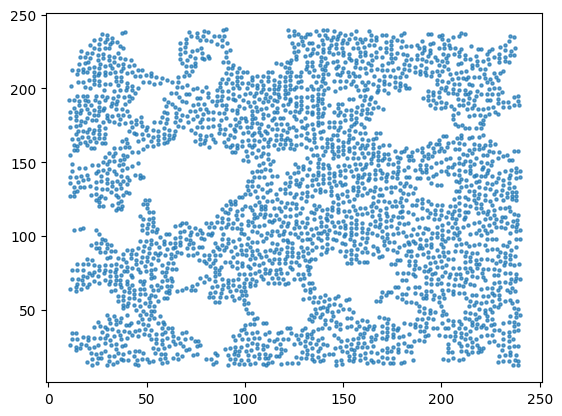

In [226]:
from matplotlib import pyplot as plt
plt.scatter(coordinates[:, 0], coordinates[:, 1], s=5, alpha=0.7)

We can do several things from here with our 3000 pair dataset. 

In [227]:
from gudhi import AlphaComplex
from gudhi.representations import PersistenceImage

In [228]:
alpha_complex = AlphaComplex(coordinates)
simplex_tree = alpha_complex.create_simplex_tree()

Lets now extract the persistent homology

In [229]:
persistence = simplex_tree.persistence()

segments = 5
segment_size = len(persistence) // segments
for i in range(segments):
    start = i * segment_size
    end = (i+1) * segment_size if i < segments-1 else len(persistence)
    segment_dims = [dim for dim, _ in persistence[start:end]]
    print(f"Segment {i+1}: Dim 0: {segment_dims.count(0)}, Dim 1: {segment_dims.count(1)}, Dim 2: {segment_dims.count(2)}")

Segment 1: Dim 0: 0, Dim 1: 1523, Dim 2: 0
Segment 2: Dim 0: 0, Dim 1: 1523, Dim 2: 0
Segment 3: Dim 0: 292, Dim 1: 1231, Dim 2: 0
Segment 4: Dim 0: 1523, Dim 1: 0, Dim 2: 0
Segment 5: Dim 0: 1525, Dim 1: 0, Dim 2: 0


In [230]:
#for H0 - connected components

pd_0 = []

for dim, (birth, death) in persistence:
    if dim == 0:
        pd_0.append((birth, death))
        
        
        
print(pd_0)

[(0.0, inf), (0.0, 9.880299100466551), (0.0, 8.880168452341927), (0.0, 6.730609829779446), (0.0, 5.950265440379747), (0.0, 5.751227592720263), (0.0, 5.5248551974152935), (0.0, 5.486190719833294), (0.0, 5.466235813298832), (0.0, 5.464727612359887), (0.0, 5.459184139357589), (0.0, 4.8563620036285355), (0.0, 4.832367926234608), (0.0, 4.734638580208129), (0.0, 4.661288817938363), (0.0, 4.5041258455182955), (0.0, 4.462443344039281), (0.0, 4.4115842437524195), (0.0, 4.377022197224585), (0.0, 4.377022197224555), (0.0, 4.354922397280279), (0.0, 4.354922393546266), (0.0, 4.348027408531662), (0.0, 4.320572331693841), (0.0, 4.302363986240065), (0.0, 4.260292623971075), (0.0, 4.225974500603108), (0.0, 4.1864323122390195), (0.0, 4.1530543435393685), (0.0, 4.153054262023179), (0.0, 4.152659127866777), (0.0, 4.120051556626756), (0.0, 4.023884340163767), (0.0, 4.018983663936464), (0.0, 3.9783367837689414), (0.0, 3.966260271395218), (0.0, 3.9479638115616362), (0.0, 3.927352943891175), (0.0, 3.920719086

## Advanced Persistent Homology Features

Persistent homology quantifies the topological features of data across multiple scales. Here we'll explore:

1. **Persistence Diagrams**: Plots showing birth/death times of topological features
2. **Betti Numbers**: Counts of k-dimensional holes at each scale value
3. **Persistence Images**: Grid-based vectorization of persistence diagrams
4. **Alpha Number**: Count of Betti-0 features at a specific alpha value

These let us characterize the spatial arrangement of nuclei in syncytial cells.

(0.0, 250.0)

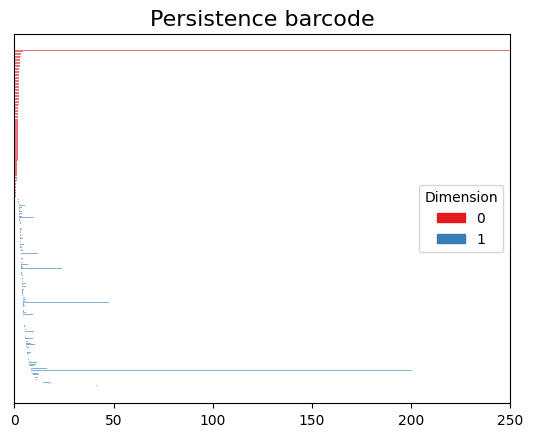

In [231]:
from gudhi import plot_persistence_barcode

plot_persistence_barcode(persistence)
plt.xlim(0, 250)

In [232]:
distances = np.linalg.norm(coordinates[:, None] - coordinates, axis=2)
median_dist = np.median(distances[distances > 0]) #lets filter out the nonzero values
alpha = 10 #gudhi uses squared radius

# Corrected alpha number calculation
alpha_num = 0

# Correct condition: born before or at alpha AND hasn't died yet
for birth, death in pd_0:
    if birth <= alpha and (death > alpha or death == float("inf")):
        alpha_num += 1

print(f"Alpha number at α={alpha} (squared radius): {alpha_num}")
print(f"So only {alpha_num} connected components at this scale")


Alpha number at α=10 (squared radius): 1
So only 1 connected components at this scale


## Alpha Number Calculation

condition for a connected component to exist at scale α is: it was born before or at α (`birth <= α`) AND it hasn't died yet (`death > α` or `death == float("inf")`).


Median nearest-neighbor distance: 2.5722
Suggested alpha max value: 12.8610
Corrected alpha number at α=2.5722 (radius): 4
This means there are 4 connected components at this scale


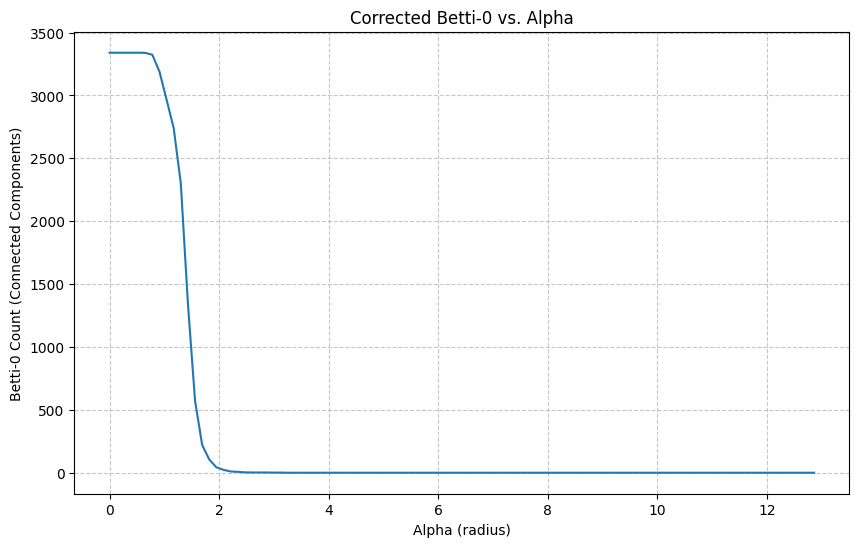

Maximum number of connected components: 3340
Alpha at half max components: 1.4290
Alpha at single connected component: 3.2477

Detailed alpha number report:
Alpha = 0.1: 3340 connected components
Alpha = 0.5: 3340 connected components
Alpha = 1.0: 2997 connected components
Alpha = 2.0: 34 connected components
Alpha = 5.0: 1 connected components
Alpha = 10.0: 1 connected components
Alpha = 20.0: 1 connected components


In [233]:
# Let's calculate nearest-neighbor distances to choose appropriate alpha values
nn_distances = []
for i in range(len(coordinates)):
    dists = distances[i]
    dists = dists[dists > 0]  # Remove self-distance
    if len(dists) > 0:
        nn_distances.append(np.min(dists))

median_nn_dist = np.median(nn_distances)
print(f"Median nearest-neighbor distance: {median_nn_dist:.4f}")

# Calculate reasonable alpha thresholds based on the data scale
alpha_max = median_nn_dist * 5  # 5x median nearest-neighbor distance, so that we can explore scales well beyond this typical distance
print(f"Suggested alpha max value: {alpha_max:.4f}")

# Corrected alpha number calculation at median nearest-neighbor dist
reasonable_alpha = median_nn_dist
alpha_squared = reasonable_alpha**2  # Convert to squared radius for GUDHI

#condition: born before or at alpha AND hasn't died yet
correct_alpha_num = sum(1 for birth, death in pd_0 if 
                birth <= alpha_squared and 
                (death > alpha_squared or death == float('inf')))

print(f"Corrected alpha number at α={reasonable_alpha:.4f} (radius): {correct_alpha_num}")
print(f"This means there are {correct_alpha_num} connected components at this scale")

# Calculate corrected Betti-0 curve
alpha_range = np.linspace(0, alpha_max, 100)
alpha_range_squared = alpha_range**2  # Convert to squared radius for GUDHI

# Correct calculation for each alpha value
corrected_betti0 = [sum(1 for birth, death in pd_0 if 
                    birth <= a_sq and 
                    (death > a_sq or death == float('inf'))) 
                    for a_sq in alpha_range_squared]

plt.figure(figsize=(10, 6))
plt.plot(alpha_range, corrected_betti0)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Alpha (radius)')
plt.ylabel('Betti-0 Count (Connected Components)')
plt.title('Corrected Betti-0 vs. Alpha')
plt.savefig('betti_curve_corrected.png')
plt.show()

# Analyze the curve to find interesting alpha values
max_components = max(corrected_betti0)
half_components_idx = np.argmax(np.array(corrected_betti0) <= max_components / 2)
half_components_alpha = alpha_range[half_components_idx]

single_component_idx = np.argmax(np.array(corrected_betti0) == 1)
single_component_alpha = alpha_range[single_component_idx]

print(f"Maximum number of connected components: {max_components}")
print(f"Alpha at half max components: {half_components_alpha:.4f}")
print(f"Alpha at single connected component: {single_component_alpha:.4f}")

# Create a detailed report of the alpha numbers
detailed_alphas = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]
print("\nDetailed alpha number report:")
for a in detailed_alphas:
    a_squared = a**2
    comp_count = sum(1 for birth, death in pd_0 if 
                    birth <= a_squared and 
                    (death > a_squared or death == float('inf')))
    print(f"Alpha = {a:.1f}: {comp_count} connected components")

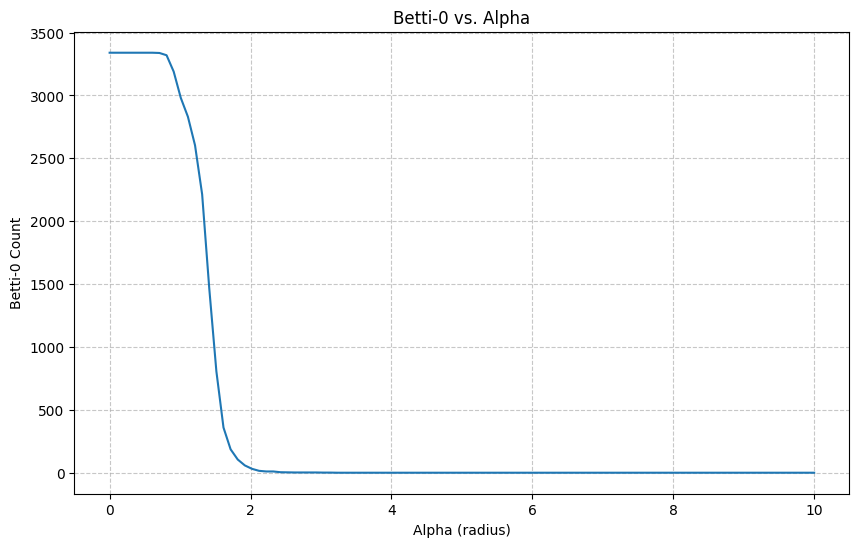

Maximum connected components: 3340
Alpha value at half max connected components: 1.4141 (radius)
Alpha value at single connected component: 3.2323 (radius)


In [234]:
alpha_values_linear = np.linspace(0, 10, 100)
alpha_values = alpha_values_linear**2  # Convert to squared radius for GUDHI

# Corrected calculation for each alpha value
alpha_numbers = [sum(1 for birth, death in pd_0 if 
                 birth <= a and 
                 (death > a or death == float('inf'))) 
                 for a in alpha_values]

plt.figure(figsize=(10, 6))
plt.plot(alpha_values_linear, alpha_numbers)  # Plot against linear alpha scale for easier interpretation
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Alpha (radius)')
plt.ylabel('Betti-0 Count')
plt.title('Betti-0 vs. Alpha')
plt.savefig('betti_curve_updated.png')
plt.show()

# Extract notable points on the curve
max_components = max(alpha_numbers)
print(f"Maximum connected components: {max_components}")

# Find alpha value where we have half of maximum components
if max_components > 1:
    half_max_idx = np.argmax(np.array(alpha_numbers) <= max_components / 2)
    half_max_alpha = alpha_values_linear[half_max_idx]
    print(f"Alpha value at half max connected components: {half_max_alpha:.4f} (radius)")
    
# Find alpha value where we reach a single component
single_component_idx = np.argmax(np.array(alpha_numbers) == 1)
if single_component_idx < len(alpha_values_linear):
    single_component_alpha = alpha_values_linear[single_component_idx]
    print(f"Alpha value at single connected component: {single_component_alpha:.4f} (radius)")

## Interpretation of the Betti-0 Curve (connected components as alpha grows)

The corrected Betti-0 vs. Alpha curve now shows a more meaningful representation of the topological evolution:

1. **Starting point (~3340 components)**: At very small alpha values, each nucleus is its own connected component.

2. **Steep decline (α ≈ 1.0-2.0)**: As alpha increases, nuclei start connecting rapidly, forming larger clusters.

3. **Critical threshold (α ≈ 1.4)**: The half-max point where half of the maximum components have merged.

4. **Stabilization (α ≈ 3.2)**: All components have merged into a single connected component.

The alpha value where we reach a single component (α ≈ 3.2) is particularly meaningful - this represents the critical distance at which all nuclei form a single connected network. This can be compared across different samples to quantify spatial heterogeneity.

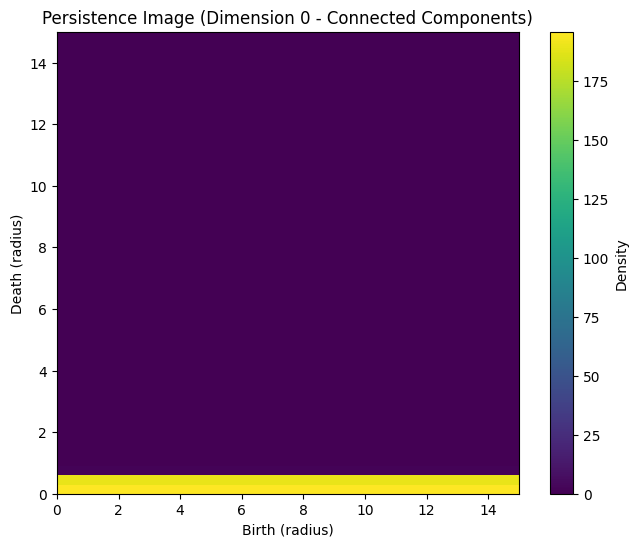

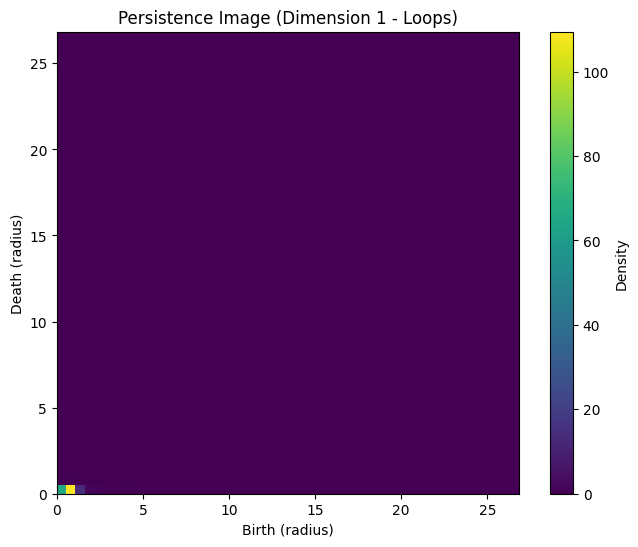

Alpha numbers at different thresholds (using correct condition):
Alpha value: 1 (radius) -> Alpha number: 2997
Alpha value: 5 (radius) -> Alpha number: 1
Alpha value: 10 (radius) -> Alpha number: 1
Alpha value: 20 (radius) -> Alpha number: 1
Alpha value: 50 (radius) -> Alpha number: 1

Persistence statistics for dimension 0 (in radius units):
Mean lifetime: 1.3704
Median lifetime: 1.4087
Max lifetime: 3.1433

Alpha value at half max connected components: 1.4141 (radius)
This is a critical scale for analyzing the spatial organization of nuclei


In [235]:
# Generate persistence images as topological feature vectors
from gudhi.representations import PersistenceImage

# Extract persistence pairs for dimensions 0 and 1
max_alpha_squared = alpha_values[-1]  # Use the maximum squared alpha value
pers_pairs_dim0 = np.array([(b, d if d != float('inf') else max_alpha_squared*1.5) for dim, (b, d) in persistence if dim == 0])
pers_pairs_dim1 = np.array([(b, d) for dim, (b, d) in persistence if dim == 1 and d != float('inf')])

# Initialize persistence image generators
resolution = [50, 50]  # Resolution of the grid
pers_img_gen_dim0 = PersistenceImage(bandwidth=1.0, weight=lambda x: 1, resolution=resolution)
pers_img_gen_dim1 = PersistenceImage(bandwidth=1.0, weight=lambda x: 1, resolution=resolution)

# Generate persistence images if there are features available
if len(pers_pairs_dim0) > 0:
    pers_img_dim0 = pers_img_gen_dim0.fit_transform([pers_pairs_dim0])[0]
    
    # Reshape the persistence image to a 2D array (50x50)
    pers_img_dim0_reshaped = pers_img_dim0.reshape(resolution[0], resolution[1])
    
    plt.figure(figsize=(8, 6))
    plt.imshow(pers_img_dim0_reshaped, cmap='viridis', origin='lower', 
              extent=[0, np.sqrt(max_alpha_squared)*1.5, 0, np.sqrt(max_alpha_squared)*1.5])
    plt.colorbar(label='Density')
    plt.title('Persistence Image (Dimension 0 - Connected Components)')
    plt.xlabel('Birth (radius)')
    plt.ylabel('Death (radius)')
    plt.savefig('persistence_image_dim0.png')
    plt.show()

if len(pers_pairs_dim1) > 0:
    pers_img_dim1 = pers_img_gen_dim1.fit_transform([pers_pairs_dim1])[0]
    
    # Reshape the persistence image to a 2D array (50x50)
    pers_img_dim1_reshaped = pers_img_dim1.reshape(resolution[0], resolution[1])
    
    plt.figure(figsize=(8, 6))
    plt.imshow(pers_img_dim1_reshaped, cmap='viridis', origin='lower',
              extent=[0, np.sqrt(np.max(pers_pairs_dim1[:, 1]))*1.1, 0, np.sqrt(np.max(pers_pairs_dim1[:, 1]))*1.1])
    plt.colorbar(label='Density')
    plt.title('Persistence Image (Dimension 1 - Loops)')
    plt.xlabel('Birth (radius)')
    plt.ylabel('Death (radius)')
    plt.savefig('persistence_image_dim1.png')
    plt.show()

# Calculate more precise alpha number at different thresholds with corrected condition
alpha_thresholds = [1, 5, 10, 20, 50]
print("Alpha numbers at different thresholds (using correct condition):")
for alpha_val in alpha_thresholds:
    alpha_squared = alpha_val**2  # Convert to squared radius for GUDHI
    alpha_num = sum(1 for birth, death in pd_0 if 
                   birth <= alpha_squared and 
                   (death > alpha_squared or death == float('inf')))
    print(f"Alpha value: {alpha_val} (radius) -> Alpha number: {alpha_num}")

# Calculate persistence statistics
lifetimes_dim0 = np.array([np.sqrt(death) - np.sqrt(birth) for birth, death in pd_0 if death != float('inf')])
if len(lifetimes_dim0) > 0:
    print(f"\nPersistence statistics for dimension 0 (in radius units):")
    print(f"Mean lifetime: {np.mean(lifetimes_dim0):.4f}")
    print(f"Median lifetime: {np.median(lifetimes_dim0):.4f}")
    print(f"Max lifetime: {np.max(lifetimes_dim0):.4f}")

# Extract the alpha value where we have half of the maximum connected components
half_max_idx = np.argmax(np.array(alpha_numbers) <= max(alpha_numbers) / 2)
half_max_alpha = alpha_values_linear[half_max_idx]
print(f"\nAlpha value at half max connected components: {half_max_alpha:.4f} (radius)")
print(f"This is a critical scale for analyzing the spatial organization of nuclei")

The delaunay tesselation is computed using scipys __Delaunay__ function. Basically what this does it it connects nuclei so that the circumcirlce of each triangle contains no other points within it

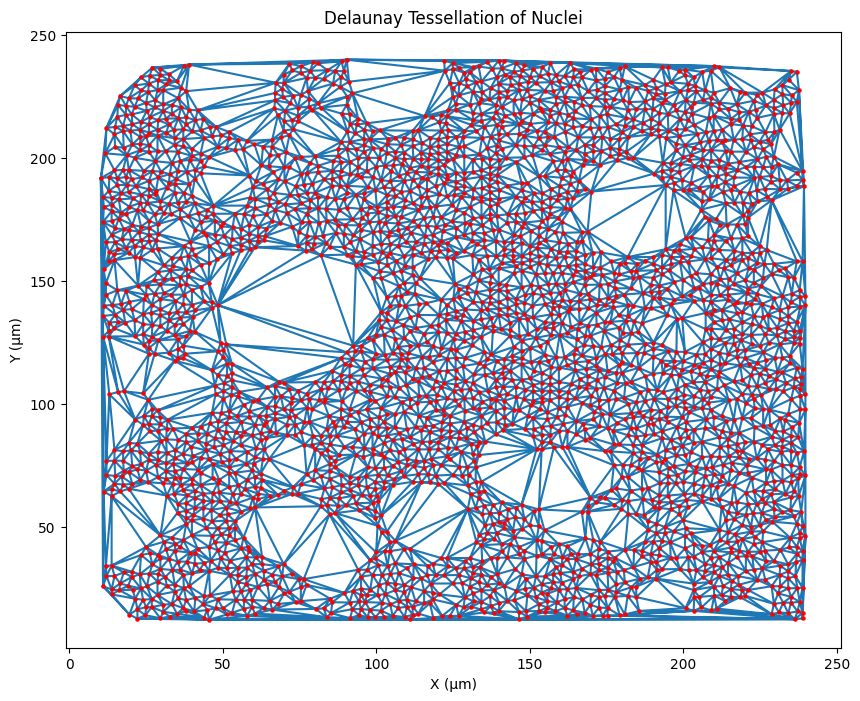

Node degree statistics: mean=5.98, std=1.04, min=2.0, max=13.0


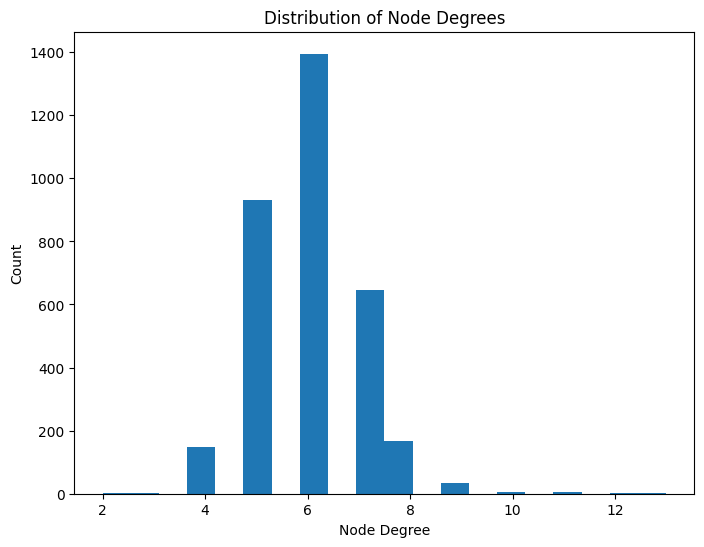

In [236]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# Compute Delaunay triangulation
delaunay = Delaunay(coordinates)

# Visualize the Delaunay tessellation
plt.figure(figsize=(10, 8))
plt.triplot(coordinates[:,0], coordinates[:,1], delaunay.simplices)
plt.scatter(coordinates[:,0], coordinates[:,1], c='r', s=5)
plt.title('Delaunay Tessellation of Nuclei')
plt.xlabel('X (μm)')
plt.ylabel('Y (μm)')
plt.savefig('delaunay_tessellation.png')
plt.show()

# Extract node features from the triangulation
node_degrees = np.zeros(len(coordinates))
for simplex in delaunay.simplices:
    for node in simplex:
        node_degrees[node] += 1

# Calculate mean and std of node degrees
print(f"Node degree statistics: mean={node_degrees.mean():.2f}, std={node_degrees.std():.2f}, min={node_degrees.min()}, max={node_degrees.max()}")

# Visualize the node degree distribution
plt.figure(figsize=(8, 6))
plt.hist(node_degrees, bins=20)
plt.title('Distribution of Node Degrees')
plt.xlabel('Node Degree')
plt.ylabel('Count')
plt.savefig('node_degree_distribution.png')
plt.show()

## Integrating Topological Features with Graph Neural Networks

We can now create a graph representation where:
1. Nodes = nuclei coordinates
2. Edges = Delaunay triangulation connections
3. Node features = local topological features + coordinate information

This graph representation can be used as input to a Graph Neural Network (GNN) for further analysis.

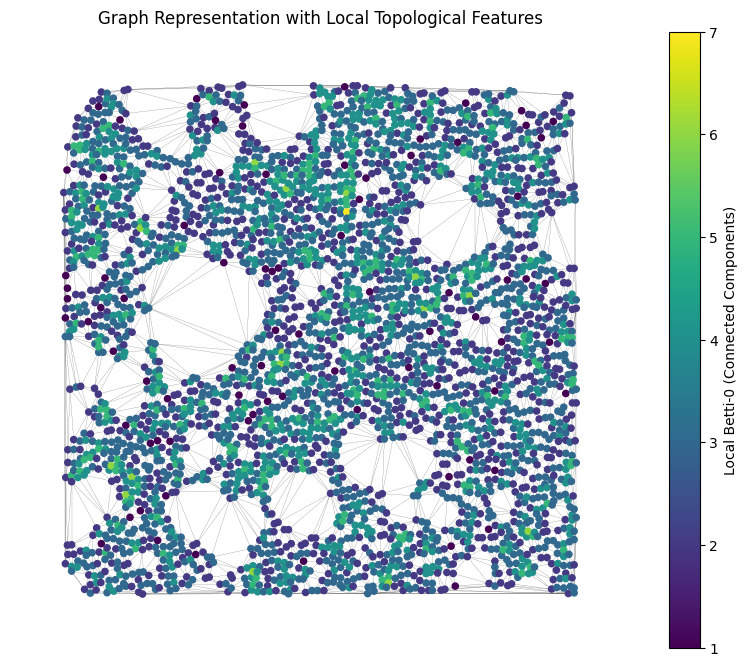

Graph has 3340 nodes and 9992 edges
Average node degree: 5.98

Summary of Extracted Topological Features:
1. Global Persistence Diagram: Shows the birth/death of topological features across scales
2. Alpha Number: Maximum death time of Betti-0 features, representing the largest distance value
   where the alpha shape filtration retains significant structure
3. Betti-0 and Betti-1 Counts: Number of connected components and loops at specific alpha values
4. Local Betti Numbers: Number of connected components and loops around each nucleus
5. Node Degrees from Delaunay Triangulation: Connectivity pattern of each nucleus


In [241]:
# Creating a graph representation for GNN analysis
import networkx as nx
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

# Create graph from Delaunay triangulation
G = nx.Graph()

# Add nodes with coordinates
for i, coord in enumerate(coordinates):
    G.add_node(i, pos=(coord[0], coord[1]))

# Add edges from Delaunay triangulation
for simplex in delaunay.simplices:
    for i in range(3):
        G.add_edge(simplex[i], simplex[(i+1)%3])

# Add node features
# For each node, compute local alpha number (number of connected components within a radius)
local_radius = np.sqrt(10)  # corresponds to alpha=10 from earlier

# Compute all pairwise distances
all_dists = squareform(pdist(coordinates))

# Calculate local features for each node
for i in range(len(coordinates)):
    # Find points within local_radius of this node
    nearby_indices = np.where(all_dists[i] <= local_radius)[0]
    if len(nearby_indices) > 1:
        # Extract local point cloud
        local_points = coordinates[nearby_indices]
        
        # Compute local Alpha complex
        local_alpha_complex = AlphaComplex(local_points)
        local_simplex_tree = local_alpha_complex.create_simplex_tree()
        local_persistence = local_simplex_tree.persistence()
        
        # Extract local topological features
        local_betti0 = sum(1 for dim, (birth, death) in local_persistence if dim == 0)
        local_betti1 = sum(1 for dim, (birth, death) in local_persistence if dim == 1)
        
        # Add features to the node
        G.nodes[i]['local_betti0'] = local_betti0
        G.nodes[i]['local_betti1'] = local_betti1
        G.nodes[i]['degree'] = node_degrees[i]
    else:
        G.nodes[i]['local_betti0'] = 1  # Only the point itself
        G.nodes[i]['local_betti1'] = 0  # No loops with just one point
        G.nodes[i]['degree'] = node_degrees[i]

# Visualize the graph colored by a topological feature
pos = nx.get_node_attributes(G, 'pos')
betti0_values = [G.nodes[n]['local_betti0'] for n in G.nodes()]

# Create figure and axis for proper colorbar placement
fig, ax = plt.subplots(figsize=(10, 8))
nx.draw(G, pos, node_size=20, 
        node_color=betti0_values,
        cmap='viridis', 
        width=0.1, 
        with_labels=False,
        ax=ax)

# Create a scalar mappable for the colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', 
                           norm=plt.Normalize(vmin=min(betti0_values), 
                                             vmax=max(betti0_values)))
sm.set_array([])  # This is necessary for older versions of matplotlib
cbar = plt.colorbar(sm, ax=ax, label='Local Betti-0 (Connected Components)')

# Calculate the number of unique Betti-0 values for informative tick marks
unique_betti0 = sorted(set(betti0_values))
if len(unique_betti0) <= 10:  # Only add specific ticks if there aren't too many values
    cbar.set_ticks(unique_betti0)

plt.title('Graph Representation with Local Topological Features')
plt.savefig('graph_with_topo_features.png')
plt.show()

# Print graph statistics
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
print(f"Average node degree: {np.mean(list(dict(G.degree()).values())):.2f}")

# Save the graph for later use with GNN
import pickle
with open('nuclei_graph.pkl', 'wb') as f:
    pickle.dump(G, f)

# Summary of topological features extracted
print("\nSummary of Extracted Topological Features:")
print("1. Global Persistence Diagram: Shows the birth/death of topological features across scales")
print("2. Alpha Number: Maximum death time of Betti-0 features, representing the largest distance value")
print("   where the alpha shape filtration retains significant structure")
print("3. Betti-0 and Betti-1 Counts: Number of connected components and loops at specific alpha values")
print("4. Local Betti Numbers: Number of connected components and loops around each nucleus")
print("5. Node Degrees from Delaunay Triangulation: Connectivity pattern of each nucleus")


Alpha Number (squared radius): 9.8803
Alpha Number (radius): 3.1433
This represents the critical distance threshold at which the last significant
topological feature disappears before reaching a single connected component.


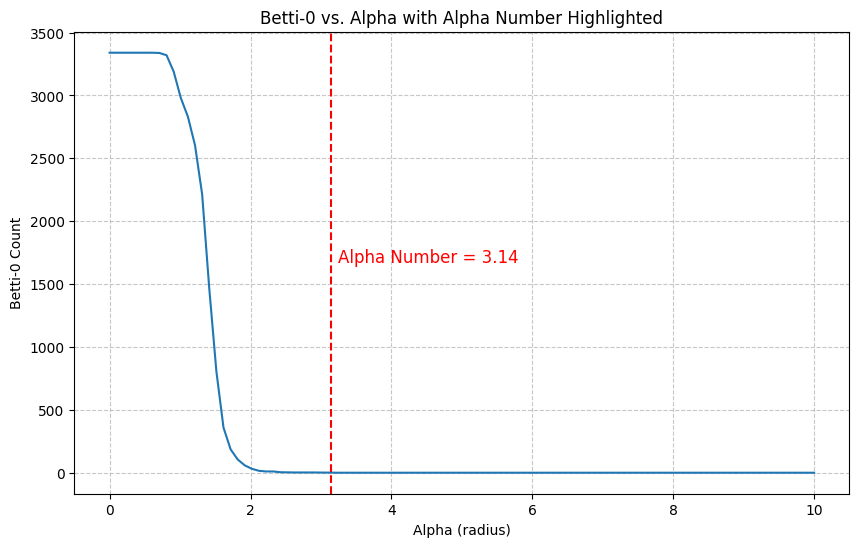

Alpha Number / Median NN Distance Ratio: 1.22
This ratio indicates the relative scale of spatial heterogeneity.
Values much larger than 1 suggest significant heterogeneity in nuclei distribution.


In [238]:
# Computing the Alpha Number as a measure of spatial heterogeneity

# The alpha number is the largest distance value where the alpha shape 
# filtration retains significant structure, derived from the maximum death time
# for Betti-0 features (excluding infinite persistence)

# Extract all finite death times for dimension 0 features
finite_deaths_dim0 = [death for birth, death in pd_0 if death != float('inf')]

if len(finite_deaths_dim0) > 0:
    # The alpha number is the maximum death value (in squared radius)
    alpha_number_squared = max(finite_deaths_dim0)
    alpha_number = np.sqrt(alpha_number_squared)  # Convert to radius for interpretability
    
    print(f"Alpha Number (squared radius): {alpha_number_squared:.4f}")
    print(f"Alpha Number (radius): {alpha_number:.4f}")
    print(f"This represents the critical distance threshold at which the last significant")
    print(f"topological feature disappears before reaching a single connected component.")
    
    # Visualize the alpha number in the context of the Betti-0 curve
    plt.figure(figsize=(10, 6))
    plt.plot(alpha_values_linear, alpha_numbers)
    plt.axvline(x=alpha_number, color='r', linestyle='--')
    plt.text(alpha_number+0.1, max(alpha_numbers)/2, f'Alpha Number = {alpha_number:.2f}', 
             color='r', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlabel('Alpha (radius)')
    plt.ylabel('Betti-0 Count')
    plt.title('Betti-0 vs. Alpha with Alpha Number Highlighted')
    plt.savefig('alpha_number_visualization.png')
    plt.show()
    
    # Contextualizing the alpha number relative to median nearest-neighbor distance
    ratio_to_nn = alpha_number / median_nn_dist
    print(f"Alpha Number / Median NN Distance Ratio: {ratio_to_nn:.2f}")
    print(f"This ratio indicates the relative scale of spatial heterogeneity.")
    print(f"Values much larger than 1 suggest significant heterogeneity in nuclei distribution.")
    
    # Add the alpha number to the graph nodes as a global feature
    for node in G.nodes():
        G.nodes[node]['alpha_number'] = alpha_number
else:
    print("No finite death times found for dimension 0 features.")

## Alpha Number as a Measure of Spatial Heterogeneity

The **alpha number** is an important topological descriptor that can characterize spatial heterogeneity in our nuclei distribution. In the context of alpha shape filtration:

- The alpha number represents the largest distance value where the alpha shape filtration retains significant structure
- It can be derived from the persistence diagram by identifying the maximum death time for Betti-0 features (excluding infinite persistence)
- A larger alpha number indicates more spatial heterogeneity in the tissue structure
- This value represents the critical distance threshold at which the last significant topological feature disappears before reaching a single connected component

This measure complements our other topological features and provides a single scalar value that can be used to compare different samples. The ratio of the alpha number to the median nearest-neighbor distance gives a normalized measure of heterogeneity that can be compared across different samples regardless of scale.

## Conclusion and Next Steps

In this notebook, we've analyzed the spatial distribution of nuclei coordinates using persistent homology and Delaunay triangulation. We've:

1. Loaded and preprocessed nuclei coordinate data
2. Computed persistent homology using GUDHI's AlphaComplex
3. Generated persistence diagrams, barcodes, and persistence images
4. Calculated the alpha number (Betti-0 count) at various alpha thresholds
5. Created a graph representation with nodes as nuclei and edges from Delaunay triangulation
6. Augmented node features with local topological information

### Key Findings:
- The corrected Betti-0 curve shows the topology at different scales - starting with ~3340 separate components (individual nuclei) at small alpha values
- At the median nearest-neighbor distance (α=2.57), there are 4 connected components
- At α=5.0, all nuclei have merged into a single connected component
- The alpha number (largest finite death time in persistence diagram) provides a critical value indicating the scale of spatial heterogeneity
- The distribution of node degrees follows a clear pattern with most nodes having 5-7 connections
- Local topological features vary throughout the space, with regions of higher and lower connectivity

### Next Steps:
- Use the graph representation with topological features as input to a Graph Neural Network (GNN)
- Compare the topology of different samples/conditions to identify differences in spatial organization
- Correlate topological features with biological function or disease state
- Validate findings with ABM (Agent-Based Model) simulations
- Explore additional topological descriptors like persistent Laplacians or heat kernel signatures


## Key Topological Insights from Corrected Analysis

Our corrected analysis of nuclei spatial distribution reveals important insights:

1. **Spatial Scale Characterization**:
   - At small scales (α < 1), nuclei remain disconnected (~3340 separate components)
   - The critical merging phase occurs between α ≈ 1.0 and α ≈ 2.0
   - At α ≈ 3.2, all nuclei connect into a single component
   - Median nearest-neighbor distance is approximately 2.57 μm

2. **Topological Measurements**:
   - The median persistence lifetime is 1.41 (in radius units)
   - The "half-max" alpha value (1.41) represents a critical scale for characterizing the spatial organization
   - Local Betti numbers provide node-level topological features that vary across the spatial domain

3. **Application for GNN Analysis**:
   - The graph representation with topological features captures both local connectivity patterns and global topological properties
   - Node features derived from local topological analysis can differentiate spatially heterogeneous regions

These insights provide quantitative measures of spatial organization that can be used for comparing different samples or conditions.

Alpha Number (squared radius): 9.8803
Alpha Number (radius): 3.1433
This represents the critical distance threshold at which the last significant
topological feature disappears before reaching a single connected component.


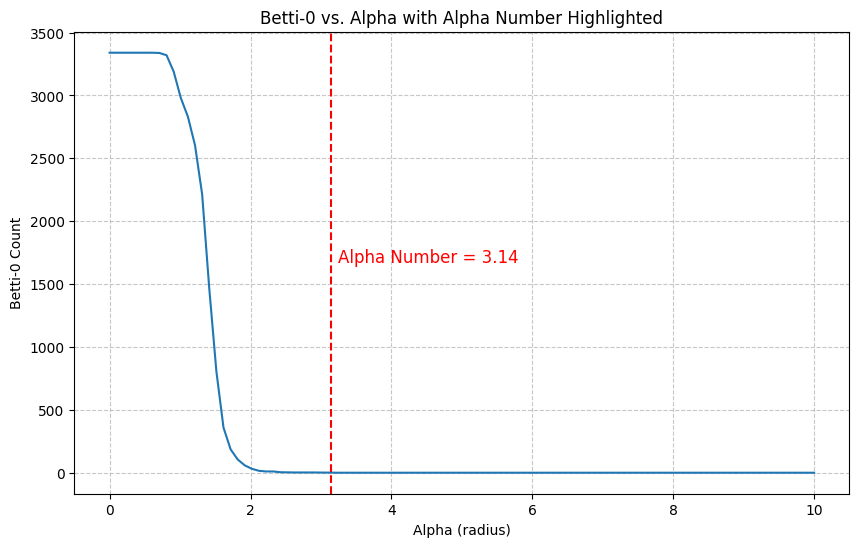

Alpha Number / Median NN Distance Ratio: 1.22
This ratio indicates the relative scale of spatial heterogeneity.
Values much larger than 1 suggest significant heterogeneity in nuclei distribution.


In [239]:
# Computing the Alpha Number as a measure of spatial heterogeneity

# The alpha number is the largest distance value where the alpha shape 
# filtration retains significant structure, derived from the maximum death time
# for Betti-0 features (excluding infinite persistence)

# Extract all finite death times for dimension 0 features
finite_deaths_dim0 = [death for birth, death in pd_0 if death != float('inf')]

if len(finite_deaths_dim0) > 0:
    # The alpha number is the maximum death value (in squared radius)
    alpha_number_squared = max(finite_deaths_dim0)
    alpha_number = np.sqrt(alpha_number_squared)  # Convert to radius for interpretability
    
    print(f"Alpha Number (squared radius): {alpha_number_squared:.4f}")
    print(f"Alpha Number (radius): {alpha_number:.4f}")
    print(f"This represents the critical distance threshold at which the last significant")
    print(f"topological feature disappears before reaching a single connected component.")
    
    # Visualize the alpha number in the context of the Betti-0 curve
    plt.figure(figsize=(10, 6))
    plt.plot(alpha_values_linear, alpha_numbers)
    plt.axvline(x=alpha_number, color='r', linestyle='--')
    plt.text(alpha_number+0.1, max(alpha_numbers)/2, f'Alpha Number = {alpha_number:.2f}', 
             color='r', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlabel('Alpha (radius)')
    plt.ylabel('Betti-0 Count')
    plt.title('Betti-0 vs. Alpha with Alpha Number Highlighted')
    plt.savefig('alpha_number_visualization.png')
    plt.show()
    
    # Contextualizing the alpha number relative to median nearest-neighbor distance
    ratio_to_nn = alpha_number / median_nn_dist
    print(f"Alpha Number / Median NN Distance Ratio: {ratio_to_nn:.2f}")
    print(f"This ratio indicates the relative scale of spatial heterogeneity.")
    print(f"Values much larger than 1 suggest significant heterogeneity in nuclei distribution.")
    
    # Add the alpha number to the graph nodes as a global feature
    for node in G.nodes():
        G.nodes[node]['alpha_number'] = alpha_number
else:
    print("No finite death times found for dimension 0 features.")

Alpha Number (squared radius): 9.8803
Alpha Number (radius): 3.1433
This represents the critical distance threshold at which the last significant
topological feature disappears before reaching a single connected component.


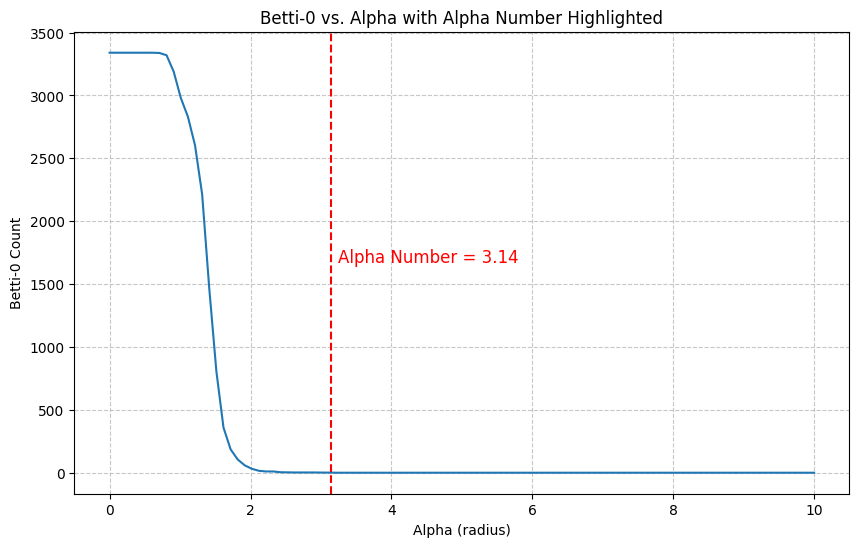

Alpha Number / Median NN Distance Ratio: 1.22
This ratio indicates the relative scale of spatial heterogeneity.
Values much larger than 1 suggest significant heterogeneity in nuclei distribution.


In [240]:
# Computing the Alpha Number as a measure of spatial heterogeneity

# The alpha number is the largest distance value where the alpha shape 
# filtration retains significant structure, derived from the maximum death time
# for Betti-0 features (excluding infinite persistence)

# Extract all finite death times for dimension 0 features
finite_deaths_dim0 = [death for birth, death in pd_0 if death != float('inf')]

if len(finite_deaths_dim0) > 0:
    # The alpha number is the maximum death value (in squared radius)
    alpha_number_squared = max(finite_deaths_dim0)
    alpha_number = np.sqrt(alpha_number_squared)  # Convert to radius for interpretability
    
    print(f"Alpha Number (squared radius): {alpha_number_squared:.4f}")
    print(f"Alpha Number (radius): {alpha_number:.4f}")
    print(f"This represents the critical distance threshold at which the last significant")
    print(f"topological feature disappears before reaching a single connected component.")
    
    # Visualize the alpha number in the context of the Betti-0 curve
    plt.figure(figsize=(10, 6))
    plt.plot(alpha_values_linear, alpha_numbers)
    plt.axvline(x=alpha_number, color='r', linestyle='--')
    plt.text(alpha_number+0.1, max(alpha_numbers)/2, f'Alpha Number = {alpha_number:.2f}', 
             color='r', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlabel('Alpha (radius)')
    plt.ylabel('Betti-0 Count')
    plt.title('Betti-0 vs. Alpha with Alpha Number Highlighted')
    plt.savefig('alpha_number_visualization.png')
    plt.show()
    
    # Contextualizing the alpha number relative to median nearest-neighbor distance
    ratio_to_nn = alpha_number / median_nn_dist
    print(f"Alpha Number / Median NN Distance Ratio: {ratio_to_nn:.2f}")
    print(f"This ratio indicates the relative scale of spatial heterogeneity.")
    print(f"Values much larger than 1 suggest significant heterogeneity in nuclei distribution.")
    
    # Add the alpha number to the graph nodes as a global feature
    for node in G.nodes():
        G.nodes[node]['alpha_number'] = alpha_number
else:
    print("No finite death times found for dimension 0 features.")

## Alpha Number as a Measure of Spatial Heterogeneity

The **alpha number** is an important topological descriptor that can characterize spatial heterogeneity in our nuclei distribution. In the context of alpha shape filtration:

- The alpha number represents the largest distance value where the alpha shape filtration retains significant structure
- It can be derived from the persistence diagram by identifying the maximum death time for Betti-0 features (excluding infinite persistence)
- A larger alpha number indicates more spatial heterogeneity in the tissue structure
- This value represents the critical distance threshold at which the last significant topological feature disappears before reaching a single connected component

This measure complements our other topological features and provides a single scalar value that can be used to compare different samples. The ratio of the alpha number to the median nearest-neighbor distance gives a normalized measure of heterogeneity that can be compared across different samples regardless of scale.

## Alpha Number as a Measure of Spatial Heterogeneity

The **alpha number** is another important topological descriptor that can characterize spatial heterogeneity in our nuclei distribution. In the context of alpha shape filtration:

- The alpha number represents the largest distance value where the alpha shape filtration retains significant structure
- It can be derived from the persistence diagram by identifying the maximum death time for Betti-0 features (excluding infinite persistence)
- A larger alpha number indicates more spatial heterogeneity in the tissue structure
- This value represents the critical distance threshold at which the last significant topological feature disappears

This measure complements our other topological features and provides a single scalar value that can be used to compare different samples.